<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/combined_approaches/LSTM_Boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import zscore
from multiprocessing import Pool

In [81]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Aquisição dos Dados

In [82]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)

In [83]:
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# classes = classes[0: -1]

#2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [84]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')

In [85]:
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


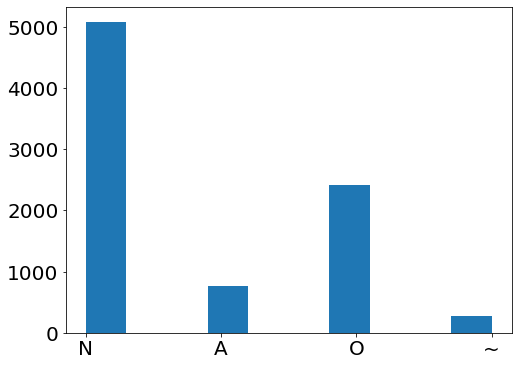

In [86]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('init_distri.png')
plt.show()

In [87]:
!pip install biosppy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import biosppy

In [89]:
classes_array = ['N', 'O', 'A', '~']

In [90]:
def window_2(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection) + 1
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    
    samples.append(signal[begin:end])

  
  return samples

In [91]:
def window(data, lsup=None, linf=None):
  samples = []
  count = 1
  peaks =  biosppy.signals.ecg.christov_segmenter(signal=data, sampling_rate = 300)[0]
  for i in (peaks[1:-1]):
      diff1 = abs(peaks[count - 1] - i)
      diff2 = abs(peaks[count + 1]- i)
      x = peaks[count - 1] + diff1//2
      y = peaks[count + 1] - diff2//2
      signal = data[x:y]
    
      if lsup != None: 
          if (lsup >= len(signal) and len(signal) >= linf): 
            samples.append(signal)
      else:
        samples.append(signal)
            
      count += 1
  if lsup != None:  
    if len(samples) == 0:
        samples = window_2(data, 0, int(np.floor(lsup)), "max")
        
  return samples

In [92]:
def embalance_data(df, classes_array, lsup = None, linf = None):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:
    aux = []
    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], lsup, linf)
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [93]:
# x_rem, x_test, y_rem, y_test = train_test_split(df["signals"], df["classes"], test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(df["signals"], df["classes"], test_size=0.15, shuffle=False)

d_aux_train = pd.DataFrame({'signals': x_train, 'classes': y_train})
d_aux_valid = pd.DataFrame({'signals': x_valid, 'classes': y_valid})

#Geração dos datasets com as amostras
# d_train = embalance_data(d_aux_train, classes_array)
# d_valid = embalance_data(d_aux_valid, classes_array)


In [94]:
d_train = pd.read_hdf('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/d_train.h5', 'table')
d_valid = pd.read_hdf('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/d_valid.h5', 'table')

In [95]:
b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 258.7
Std: 86.88
Qntd: 148080
Min: 28
---------------
O
Média: 249.1
Std: 117.33
Qntd: 78581
Min: 23
---------------
A
Média: 203.41
Std: 84.05
Qntd: 28326
Min: 38
---------------
~
Média: 291.58
Std: 312.05
Qntd: 4707
Min: 20
---------------


In [96]:
from sklearn.utils import shuffle
aux = shuffle(d_train)

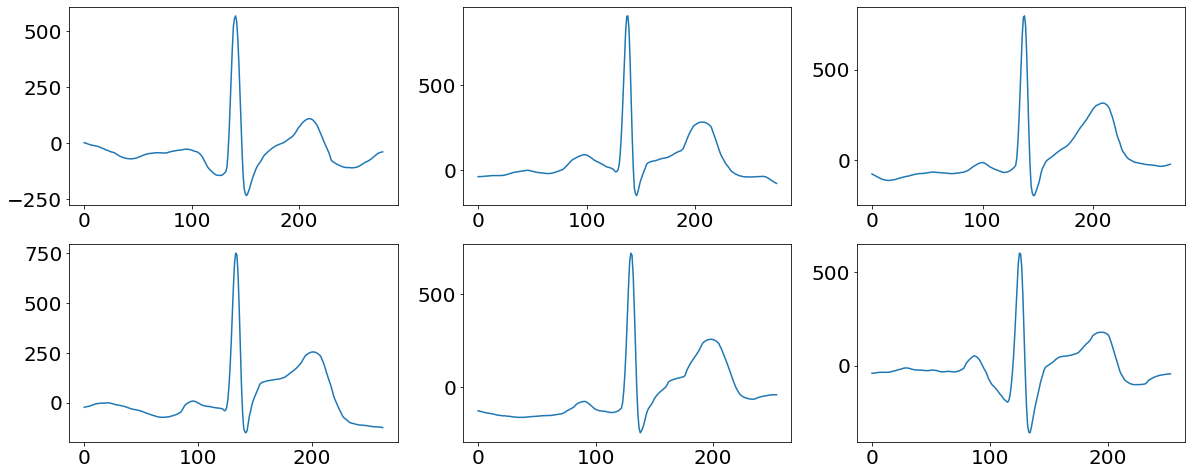

In [97]:
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(2, 3)

count = 0
for i in range(2):
  for j in range(3):
    ax[i, j].plot(aux["signals"][count])
    count += 1

In [98]:
sizes = []
for i in d_train["signals"]:
  sizes.append(len(i))

In [99]:
def rm_outliers(vector):
  vector.sort() 
  size = len(vector)
  mean = sum(vector)/len(vector)
  q1 = vector[round(0.25*size) - 1]
  q3 = vector[round(0.75*size) - 1]
  iqr = q3-q1
  linf = mean - 1.5*iqr
  lsup = mean + 1.5*iqr

  # new_vec = []
  # for i in vector:
  #   if i >= linf and i <=lsup:
  #     new_vec.append(i)

  return linf, lsup

In [100]:
# linf, lsup = rm_outliers(sizes)
linf = 134.85932289540767
lsup = 365.8593228954077

In [101]:
print(linf, lsup)

134.85932289540767 365.8593228954077


In [102]:
# Salvar DataFrames
# d_train = embalance_data(d_aux_train, classes_array, lsup, linf)
# d_valid = embalance_data(d_aux_valid, classes_array, lsup, linf)

# d_train.to_hdf('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/d_train_2.h5','table')
# d_valid.to_hdf('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/d_valid_2.h5','table')

# Carregar DataFrames
d_train = pd.read_hdf('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/d_train_2.h5', 'table')
d_valid = pd.read_hdf('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/d_valid_2.h5', 'table')

In [103]:
len(d_train["signals"])

244388

In [104]:
drop = []
for i, val in enumerate(d_train["signals"]):
  if len(val) > lsup or  len(val) < linf:
    drop.append(i)

d_train.drop(labels=drop, axis=0, inplace=True)

In [105]:
drop = []
for i, val in enumerate(d_valid["signals"]):
  if len(val) > lsup or  len(val) < linf:
    drop.append(i)

d_valid.drop(labels=drop, axis=0, inplace=True)

In [106]:
len(d_train["signals"])

244388

In [107]:
import math

In [108]:
def norm_len(signals):
  cont = -1
  x = []

  for sig in signals:
    cont += 1

    n = math.floor(lsup) - len(sig)

    zeros = np.zeros(int(n))
    x += list(np.concatenate((sig, zeros), axis=None))

  x = np.array(x)
  x = x.reshape(-1, 1, math.floor(lsup))

  return x   

In [109]:
x_train = norm_len(d_train["signals"])
x_valid = norm_len(d_valid["signals"])

In [110]:
y_train = pd.get_dummies(d_train["classes"])
y_valid = pd.get_dummies(d_valid["classes"])

In [111]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, concatenate
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, LSTM

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [112]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [113]:
from keras import backend as K

In [114]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [115]:
inp_shape = int(np.floor(lsup))

In [ ]:
path_check = 'drive/MyDrive/CNN_Chagas/Physionet/cnn-1d'

In [ ]:
classificador_1 = Sequential()

classificador_1.add(LSTM(units=128, return_sequences = True,
                       dropout=0.22, recurrent_dropout=0.44, input_shape=(1, inp_shape)
                       ))

classificador_1.add(LSTM(units=128, return_sequences = True, dropout=0.35, recurrent_dropout=0.36))

classificador_1.add(Flatten())

classificador_1.add(Dense(256, activation='relu'))
classificador_1.add(Dropout(0.25))
# classificador_1.add(Dense(64, activation='relu'))
# classificador_1.add(Dropout(0.25))
# classificador_1.add(Dense(8, activation='relu'))
# classificador_1.add(Dropout(0.25))

classificador_1.add(Dense(4, activation='softmax'))

classificador_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.015), metrics=["accuracy"])

es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=20)

checkpoint = ModelCheckpoint('_pesos_lstm1.hdf5', monitor="val_accuracy", verbose=1, 
                                  save_best_only=True, mode='max') 

history_1 = classificador_1.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
                                epochs=150, callbacks=[es, checkpoint], verbose=1, use_multiprocessing=True, workers=8)

Epoch 1/150
7635/7638 [============================>.] - ETA: 0s - loss: 0.9280 - accuracy: 0.6165
Epoch 1: val_accuracy improved from -inf to 0.62852, saving model to _pesos_lstm1.hdf5
7638/7638 [==============================] - 101s 12ms/step - loss: 0.9281 - accuracy: 0.6165 - val_loss: 0.8995 - val_accuracy: 0.6285
Epoch 2/150
7638/7638 [==============================] - ETA: 0s - loss: 0.9162 - accuracy: 0.6223
Epoch 2: val_accuracy did not improve from 0.62852
7638/7638 [==============================] - 92s 12ms/step - loss: 0.9162 - accuracy: 0.6223 - val_loss: 0.9019 - val_accuracy: 0.6267
Epoch 3/150
7635/7638 [============================>.] - ETA: 0s - loss: 0.9123 - accuracy: 0.6229
Epoch 3: val_accuracy did not improve from 0.62852
7638/7638 [==============================] - 90s 12ms/step - loss: 0.9123 - accuracy: 0.6230 - val_loss: 0.9052 - val_accuracy: 0.6282
Epoch 4/150
7634/7638 [============================>.] - ETA: 0s - loss: 0.9107 - accuracy: 0.6238
Epoch 4: 

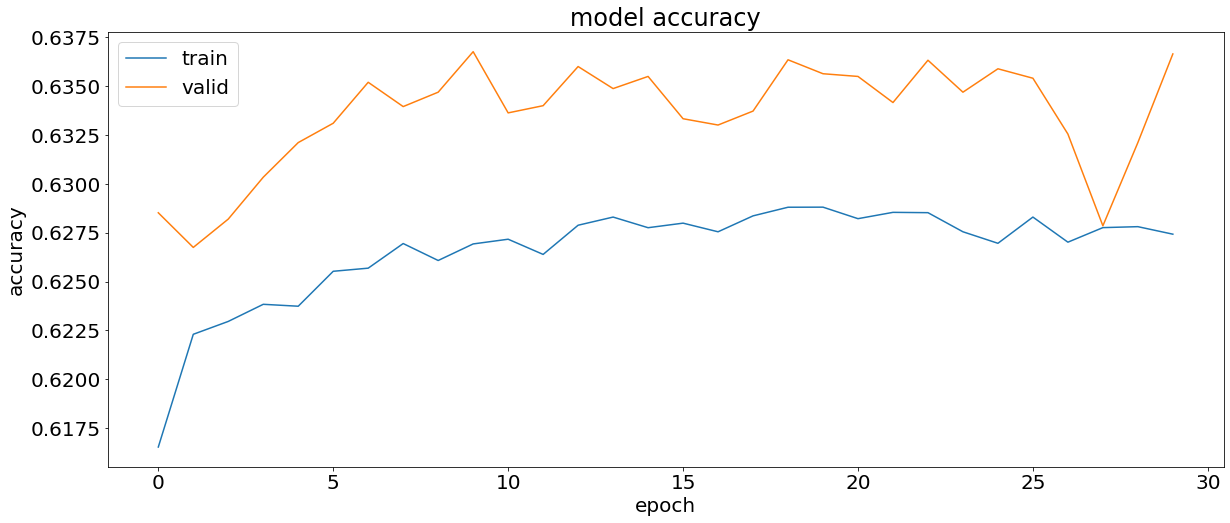

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Modelo 1 de LSTM

In [ ]:
str(type(classificador_1.layers[0])) == "<class 'keras.layers.rnn.lstm.LSTM'>"

In [ ]:
model_weights_1 =[]
for i in classificador_1.layers:
  model_weights_1.append(i.get_weights())

In [116]:
model_1 = Sequential()

model_1.add(LSTM(units=128, return_sequences = True,
                       dropout=0.22, recurrent_dropout=0.44, input_shape=(1, inp_shape)
                       ))

model_1.add(LSTM(units=128, return_sequences = True, dropout=0.35, recurrent_dropout=0.36))

model_1.add(Flatten())

model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.25))

In [ ]:
count = 0
for i in model_1.layers:
  i.set_weights(model_weights_1[count])
  count += 1

In [118]:
# model_1.save('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/add_dense')
model_1 = load_model('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/add_dense')

In [119]:
model_1.layers

## Cobinação dos modelos

In [120]:
def pooling(array, type):
  array_size = array.shape[1]
  array_qnt = array.shape[0]
  mp_vector = []

  for j in range(0, array_size):
    aux = []

    for i in range(0, array_qnt):
      aux.append(array[i][j])
      
    if type == "max":
      mp_vector.append(max(aux))

    elif  type == "avg":
      mp_vector.append(np.mean(aux))

  return mp_vector

In [121]:
def combine_windows(df, model_1, lsup, linf):

  get_final_output_1 = K.function([model_1.layers[0].input],
                                  [model_1.layers[-1].output])

  new_inputs = []
    
  for element in df["signals"]:
    samples = window(element, lsup, linf)
    outputs_1 = []

    samples = norm_len(samples)

    for sample in samples:
      sample = np.array(list(sample))
      sample = sample.reshape(1, 1, sample.shape[1])
      
      output_1 = get_final_output_1(sample)
      outputs_1.append(output_1)

    outputs_1 = np.array(outputs_1)
    outputs_1 = outputs_1.reshape(outputs_1.shape[0], outputs_1.shape[-1])

    max_p = pooling(outputs_1, "max")
    avg_p = pooling(outputs_1, "avg")

    #print(print(max_p))
    #print(type(avg_p))
    #print(print(outputs_2))

    new_inputs.append(max_p + avg_p)

  return new_inputs


In [122]:
new_inputs = combine_windows(d_aux_train, model_1, lsup, linf)

In [123]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
import xgboost as xgb

In [125]:
y_new = d_aux_train["classes"]
y_new = pd.get_dummies(y_new)
y_new = np.array(y_new)

In [126]:
new_inputs = np.array(new_inputs)

In [127]:
np.save("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/nt2_inputs", new_inputs)

In [128]:
new_inputs = np.load('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/nt_inputs.npy', allow_pickle=True)

In [129]:
def rm_invalid(new_inputs, y_new):
    aux = []
    aux_2 = []
    for i,x in enumerate(new_inputs):
        if len(x) != 0:
            aux.append(x)
            aux_2.append(y_new[i])
    
    return np.array(aux), np.array(aux_2)

In [130]:
new_inputs, y_new = rm_invalid(new_inputs, y_new)

In [131]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(new_inputs, y_new)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [138]:
valid_inp = combine_windows(d_aux_valid, model_1, lsup, linf)
valid_inp = np.array(valid_inp)

In [141]:
np.save("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/lstm_valid", valid_inp)
np.save("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/lstm_train", new_inputs)

In [142]:
y_new_val = d_aux_valid["classes"]
y_new_val = pd.get_dummies(y_new_val)
y_new_val = np.array(y_new_val)

valid_inp = np.array(valid_inp)

valid_inp, y_new_val = rm_invalid(valid_inp, y_new_val)

y_pred = xgb_cl.predict(valid_inp)

In [148]:
# y_pred = pd.DataFrame(y_pred)
y_new_val = pd.DataFrame(y_new_val)

# y_pred.columns = ['A', 'N', 'O', '~']
y_new_val.columns = ['A', 'N', 'O', '~']

y_new_val = y_new_val.idxmax(axis=1)
# y_pred = y_pred.idxmax(axis=1)

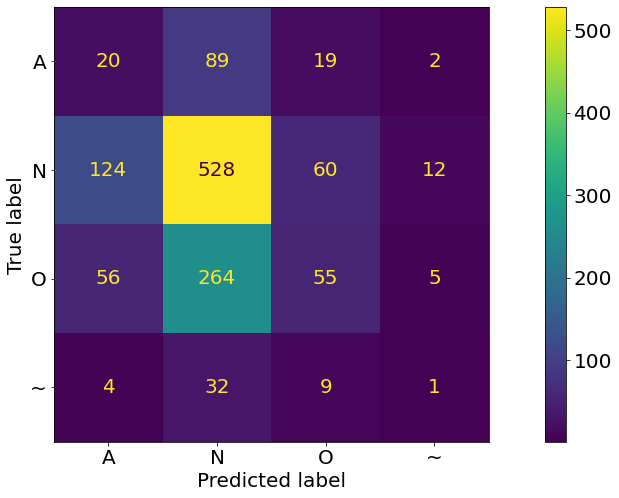

In [149]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_new_val, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()
# plt.savefig("test.png")

In [150]:
from sklearn.metrics import classification_report 
 
relatorio = classification_report(y_new_val, y_pred, target_names = ['N', 'O', 'A', '~']) 
print(relatorio)

              precision    recall  f1-score   support

           N       0.10      0.15      0.12       130
           O       0.58      0.73      0.65       724
           A       0.38      0.14      0.21       380
           ~       0.05      0.02      0.03        46

    accuracy                           0.47      1280
   macro avg       0.28      0.26      0.25      1280
weighted avg       0.45      0.47      0.44      1280



In [132]:
# while True:pass